In [65]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import RobustScaler
# plt.style.use('fivethirtyeight')

In [78]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [79]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(chris_path)
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [80]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [81]:
print(data_copy)
data_copy.shape
forecast_set = data_copy

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


In [82]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [83]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [96]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    #print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
#     print('max val king_train:')
    #print(max(king_training['king']))
    king_test[king_test["king"] < 0] = 0
#     print('max val king_test:')
    #print(max(king_test['king']))
    king_train_pre = king_training["king"].to_frame()
#     print(king_train_norm)
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    #print('king_test_norm')
    #print(king_test_norm.shape)
    #print('king_train_norm')
    #print(king_train_norm.shape)
    #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    #print(type(king_train_norm))
    #king_train_norm = king_train_norm.to_frame()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    x_train_not_norm = []
    x_test_not_norm = []
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        x_test_not_norm.append(king_test['king'][i-6:i])
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        x_train_not_norm.append(king_training['king'][i-6:i])
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm, x_test_not_norm, x_train_not_norm

In [97]:
#x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm, x_test_not_norm, x_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
#print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
#print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
#print(y_train_not_norm.shape)
#print(y_train.shape)

x_test_not_norm = np.array(x_test_not_norm)
x_test_not_norm = np.reshape(x_test_not_norm, (x_test_not_norm.shape[0],x_test_not_norm.shape[1],1))
x_train_not_norm = np.array(x_train_not_norm)
x_train_not_norm = np.reshape(x_train_not_norm, (x_train_not_norm.shape[0],x_train_not_norm.shape[1],1)).astype(np.float32)

print(x_train.shape)
print(x_test.shape)

print(x_train_not_norm.shape)
print(x_test_not_norm.shape)

(918, 6, 1)
(54, 6, 1)
(918, 6, 1)
(54, 6, 1)


In [98]:
a = [[1, 2], [3, 4]]
a = np.array(a)
a.reshape((-1, 1))
a

array([[1, 2],
       [3, 4]])

In [99]:
x_train_lr = x_train.reshape((x_train.shape[0], x_train.shape[1]))
print(x_train_lr.shape)
x_test_lr = x_test.reshape((x_test.shape[0], x_test.shape[1]))
print(x_test_lr.shape)
x_train_rr = x_train.reshape((x_train.shape[0], x_train.shape[1]))
x_test_rr = x_test.reshape((x_test.shape[0], x_test.shape[1]))
x_train_lasso = x_train.reshape((x_train.shape[0], x_train.shape[1]))
x_test_lasso = x_test.reshape((x_test.shape[0], x_test.shape[1]))
print(x_test_lasso.shape)
print(x_test.shape)


x_train_not_norm = x_train_not_norm.reshape((x_train_not_norm.shape[0], x_train_not_norm.shape[1]))
x_test_not_norm = x_test_not_norm.reshape((x_test_not_norm.shape[0], x_test_not_norm.shape[1]))

(918, 6)
(54, 6)
(54, 6)
(54, 6, 1)


In [88]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
# def day_to_year(day_preds):
#     day_preds = day_preds[183:]
#     year_preds = []
#     for i in range(365, len(day_preds), 365):   
#         salmon_count = np.sum(day_preds[i - 365:i])
#         year_preds.append(salmon_count)
#     year_preds = pd.DataFrame(year_preds, columns = ["Count"])
#     return year_preds

In [13]:
def create_linear_model(x_train, y_train, x_test, y_test, scaler): 
    '''
    creating a basic linear regression model
    '''
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    train_preds_lr = lr.predict(x_train)
    test_preds_lr = lr.predict(x_test)
    
    #Descale 
    
    train_preds_lr = scaler.inverse_transform(train_preds_lr)
    y_train = scaler.inverse_transform(y_train)
    test_preds_lr = scaler.inverse_transform(test_preds_lr)
    test_preds_lr = test_preds_lr.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return train_preds_lr, test_preds_lr, y_train, y_test

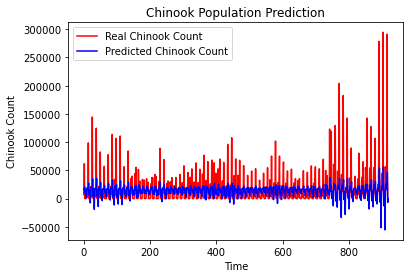

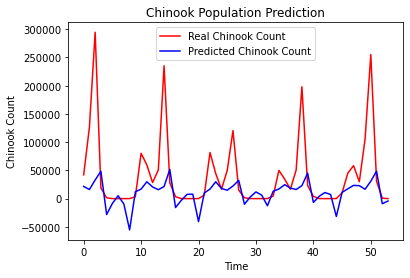

The root mean squared error is 27009.21969347456.
The root mean squared error is 68350.22719746032.


In [81]:
lr_train, lr_test, y_train, y_test = create_linear_model(x_train_lr, y_train, x_test_lr, y_test, scaler)

plot_predictions(y_train, lr_train)
plot_predictions(y_test, lr_test)
return_rmse(y_train, lr_train)
return_rmse(y_test, lr_test)

In [89]:
def create_RR_model(x_train, y_train, x_test, y_test, scaler): 
    '''
    creating a basic Ridge Regression model (L2)
    '''
    rr = Ridge(alpha=0.01)
    rr.fit(x_train, y_train)
    train_preds_rr = rr.predict(x_train)
    test_preds_rr = rr.predict(x_test)
    
    #Descale 
    
    train_preds_rr = scaler.inverse_transform(train_preds_rr)
    y_train = scaler.inverse_transform(y_train)
    test_preds_rr = scaler.inverse_transform(test_preds_rr)
    test_preds_rr = test_preds_rr.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return train_preds_rr, test_preds_rr, y_train, y_test

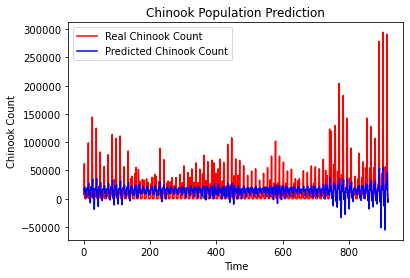

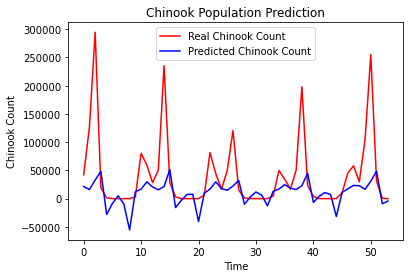

The root mean squared error is 27009.22197757247.
The root mean squared error is 68350.03056015464.


In [90]:
rr_train, rr_test, y_train, y_test = create_RR_model(x_train_rr, y_train, x_test_rr, y_test, scaler)

plot_predictions(y_train, rr_train)
plot_predictions(y_test, rr_test)
return_rmse(y_train, rr_train)
return_rmse(y_test, rr_test)

In [51]:
# def create_lasso_copy(x_train, y_train, x_test, y_test, scaler): 
#     '''
#     creating a basic Ridge Regression model (L2)
#     '''
#     transformer_x = RobustScaler().fit(x_train)
#     transformer_y = RobustScaler().fit(y_train) 
#     x_rtrain = transformer_x.transform(x_train)
#     y_rtrain = transformer_y.transform(y_train)
#     x_rtest = transformer_x.transform(x_test)
#     y_rtest = transformer_y.transform(y_test)

#     #Fit Train Model
#     lasso = Lasso()
#     lasso_alg = lasso.fit(x_rtrain,y_rtrain)

    
# #     train_score = lasso_alg.score(x_rtrain,y_rtrain)
# #     test_score = lasso_alg.score(x_rtest,y_rtest)

# #     print ("training score:", train_score)
# #     print ("test score:", test_score)

# #     example = [[10,100]]
#     train_preds_rr = transformer_y.inverse_transform(lasso.predict(x_rtrain).reshape(-1, 1))
#     test_preds_rr = transformer_y.inverse_transform(lasso.predict(x_rtest).reshape(-1, 1))
# #     train_preds_rr = scaler.inverse_transform(train_preds_rr)
#     y_train = scaler.inverse_transform(y_train)
# #     test_preds_rr = scaler.inverse_transform(test_preds_rr)
#     test_preds_rr = test_preds_rr.astype(np.int64)
#     y_test = scaler.inverse_transform(y_test)
    
#     return train_preds_rr, test_preds_rr, y_train, y_test

In [104]:
def create_lasso(x_train, y_train, x_test, y_test):
    lassoModel = Lasso(alpha = 0.1)
    lassoModel.fit(x_train, y_train)
    
    train_preds = lassoModel.predict(x_train)
    test_preds = lassoModel.predict(x_test)
    
    return train_preds, test_preds
    

/Users/chrisshell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1983623331840.0, tolerance: 434337824.0
  model = cd_fast.enet_coordinate_descent(


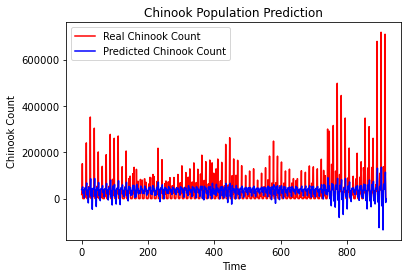

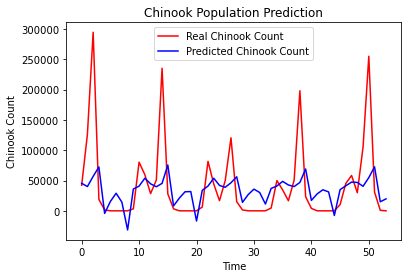

The root mean squared error is 65816.70042312301.
The root mean squared error is 61579.33041874606.


In [105]:
# lasso_train, lasso_test, y_train, y_test = create_lasso_copy(x_train_rr, y_train, x_test_rr, y_test, scaler)
lasso_train, lasso_test = create_lasso(x_train_not_norm, y_train_not_norm, x_test_not_norm, y_test_not_norm)
#lasso_train, lasso_test = create_lasso(x_train_lasso, y_train, x_test_lasso, y_test, scaler)

plot_predictions(y_train_not_norm, lasso_train)
plot_predictions(y_test_not_norm, lasso_test)
return_rmse(y_train_not_norm, lasso_train)
return_rmse(y_test_not_norm, lasso_test)

# plot_predictions(y_train, lasso_train)
# plot_predictions(y_test, lasso_test)
# return_rmse(y_train, lasso_train)
# return_rmse(y_test, lasso_test)